In [171]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [172]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [173]:
weight = 0.3
bias = 0.9

X = torch.arange(0, 10, 0.1)
X = X[torch.randperm(X.size(0))].unsqueeze(dim=1)
Y = weight * X + bias

data_split = int(0.8 * len(X))
X_tr, Y_tr = X[:data_split].to(device), Y[:data_split].to(device)
X_te, Y_te = X[data_split:].to(device), Y[data_split:].to(device)

In [174]:
def plot_predictions(train_data=X_tr.cpu(), 
                     train_labels=Y_tr.cpu(), 
                     test_data=X_te.cpu(), 
                     test_labels=Y_te.cpu(), 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=1, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=6, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

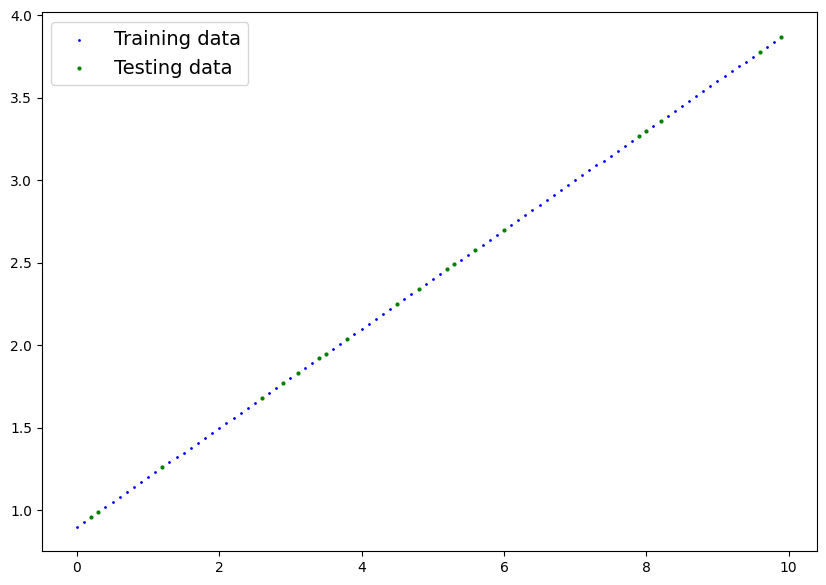

In [175]:
plot_predictions();

In [176]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear_layer(x)

In [177]:
torch.manual_seed(30)

model = Model()
model, model.state_dict()

(Model(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.8015]])),
              ('linear_layer.bias', tensor([0.4927]))]))

In [178]:
X_tr.shape, model.linear_layer.weight.shape

(torch.Size([80, 1]), torch.Size([1, 1]))

In [179]:
model.to(device)
next(model.parameters()).is_cuda

True

In [180]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [181]:
i_count = []
test_loss_values = []

for i in range(1500):
    model.train()

    # foward pass
    y_predicted = model(X_tr)

    # loss
    loss = loss_fn(y_predicted, Y_tr)

    # zero-grad
    optimizer.zero_grad()

    # backprop
    loss.backward()

    # optimization step
    optimizer.step()

    # evaluation
    model.eval()
    if i % 100 == 0:
        with torch.inference_mode():
            test_predicted = model(X_te)

            test_loss = loss_fn(test_predicted, Y_te)

            i_count.append(i)
            test_loss_values.append(test_loss.cpu())

            print(f'Iteration: {i}, loss: {test_loss}')

Iteration: 0, loss: 2.032264471054077
Iteration: 100, loss: 0.19847865402698517
Iteration: 200, loss: 0.18446819484233856
Iteration: 300, loss: 0.16675813496112823
Iteration: 400, loss: 0.14904819428920746
Iteration: 500, loss: 0.13133829832077026
Iteration: 600, loss: 0.11371896415948868
Iteration: 700, loss: 0.09600908309221268
Iteration: 800, loss: 0.07829912006855011
Iteration: 900, loss: 0.06058920547366142
Iteration: 1000, loss: 0.04287932440638542
Iteration: 1100, loss: 0.025165120139718056
Iteration: 1200, loss: 0.013098440133035183
Iteration: 1300, loss: 0.001808124827221036
Iteration: 1400, loss: 0.0016882807249203324


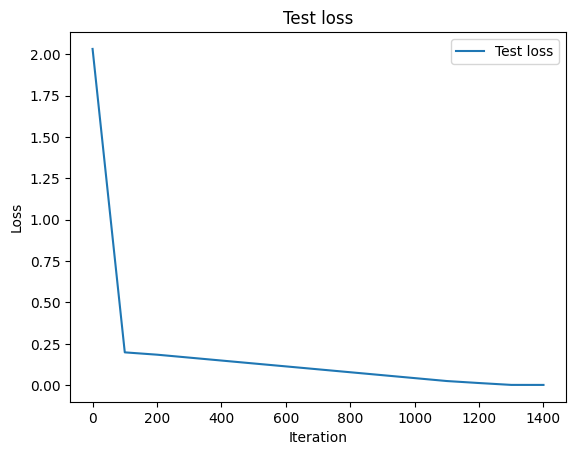

In [182]:
# Plot the loss curves
plt.plot(i_count, test_loss_values, label="Test loss")
plt.title("Test loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend();

In [183]:
print(model.state_dict())

OrderedDict({'linear_layer.weight': tensor([[0.3049]], device='cuda:0'), 'linear_layer.bias': tensor([0.9000], device='cuda:0')})


In [184]:
model.eval()

with torch.inference_mode():
    y_predicted = model(X_te)

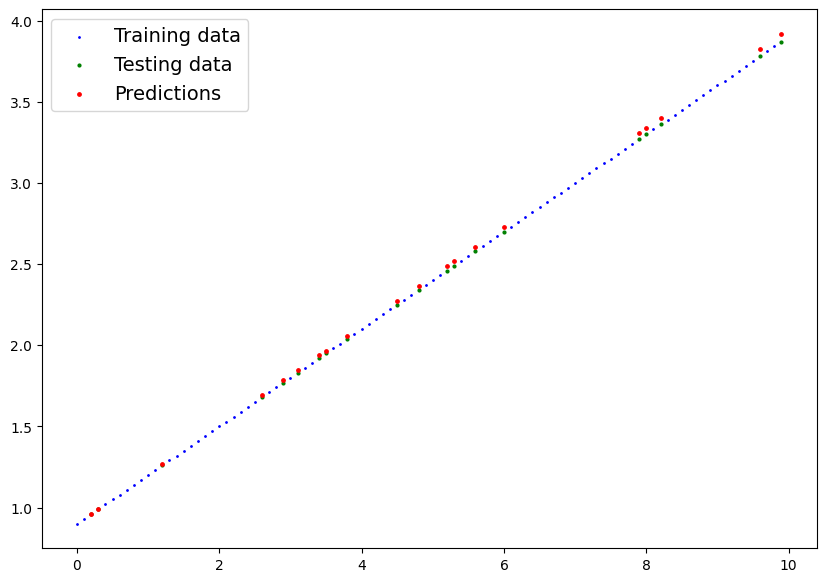

In [185]:
plot_predictions(predictions=y_predicted.cpu())

In [186]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model.pth


In [187]:
loaded_model = Model()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_te)
y_predicted == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')